In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier
# from mlops import train_model

In [8]:
df = pd.read_csv("docking.csv")

In [9]:
df.head()

,total_score,Sc,Sc_int_area,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,...,rama_prepro,ref,sc_value,side1_normalized,side1_score,side2_normalized,side2_score,yhh_planarity,description,binding
0,-875.138,0.641,1739.488,-2.392,-79.387,-2.834,-65.909,-2.353,1524.686,2801.074,...,11.144,79.056,0.629,-2.936,-167.327,-2.072,-89.093,0.000,pdb1a22_0001_0001,1
1,-1131.105,0.562,355.474,-1.029,0.000,0.000,-21.060,-2.285,681.315,921.607,...,418.072,341.033,0.670,2.512,47.721,-0.507,-8.625,0.000,pdb1am4_0001_0001,1
2,-517.596,0.746,724.205,-2.810,-46.074,-3.791,-41.043,-3.377,648.963,1215.503,...,-18.906,50.041,0.718,-2.440,-65.871,-3.154,-75.697,0.000,pdb1ay7_0001_0001,1
3,-612.908,0.521,1348.704,-1.613,-47.748,-2.095,-28.953,-1.271,1192.691,2278.870,...,81.011,144.939,0.495,-1.746,-62.855,-2.084,-108.371,0.000,pdb1bi7_0001_0001,1
4,8127.357,0.589,1157.649,9.674,0.000,0.000,-45.066,-2.156,1068.911,2090.538,...,58.777,328.817,0.610,-2.506,-87.696,-3.111,-164.863,0.000,pdb1bi8_0001_0001,1


In [10]:
# Cleaning data
description = df["description"].copy()
df = df.drop(columns=["description", "yhh_planarity"])
df.dropna(inplace=True)

/Users/claudio/miniforge3/envs/amora/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio/miniforge3/envs/amora/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio/miniforge3/envs/amora/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio/miniforge3/envs/amora/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Best number of clusters: 2


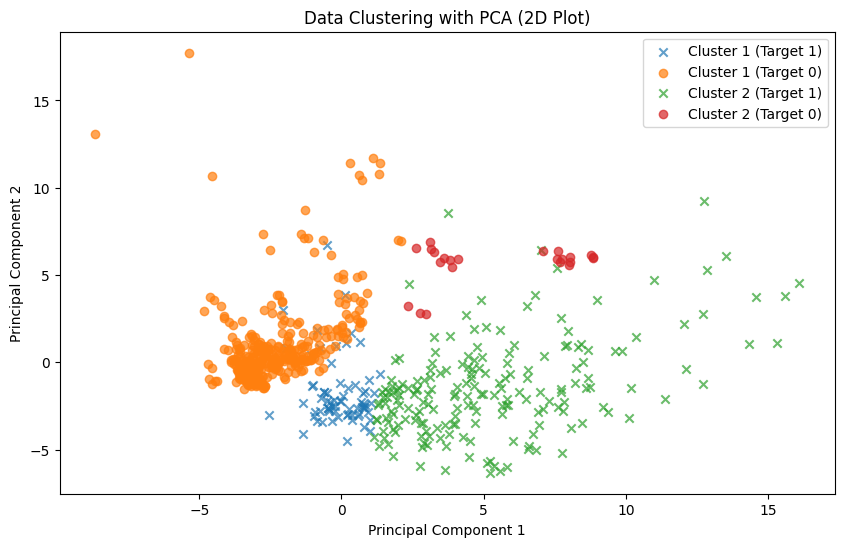

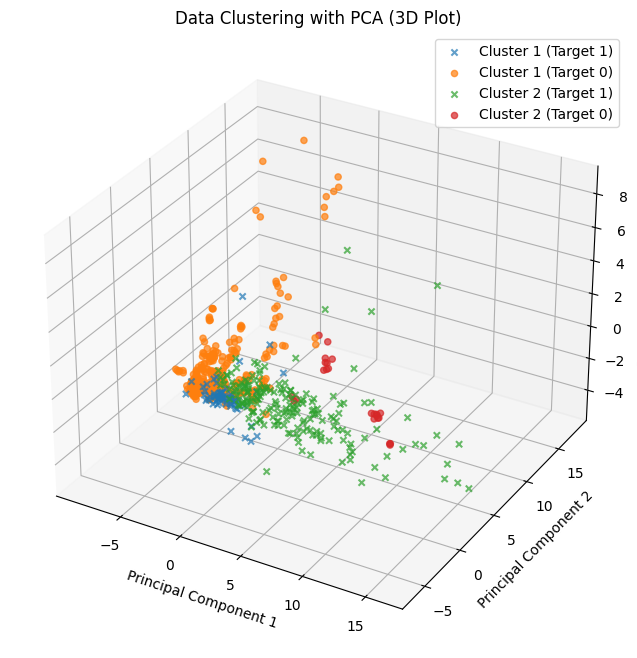

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def remove_outliers(df):
    z_scores = pd.DataFrame((df - df.mean()) / df.std())

    threshold = 3
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]

    return df_no_outliers

def cluster_and_plot(df, target_col):
    df_no_outliers = remove_outliers(df)

    X = df_no_outliers.drop(columns=[target_col])
    y = df_no_outliers[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    silhouette_scores = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)

    best_k = np.argmax(silhouette_scores) + 2
    print(f"Best number of clusters: {best_k}")

    kmeans = KMeans(n_clusters=best_k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    df["cluster"] = labels

    pca = PCA(n_components=3)
    components = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    for cluster in range(best_k):
        cluster_data = components[labels == cluster]
        target_data = y[labels == cluster]
        
        plt.scatter(cluster_data[target_data == 1, 0], cluster_data[target_data == 1, 1],
                    marker='x', label=f"Cluster {cluster + 1} (Target 1)", alpha=0.7)
        plt.scatter(cluster_data[target_data == 0, 0], cluster_data[target_data == 0, 1],
                    marker='o', label=f"Cluster {cluster + 1} (Target 0)", alpha=0.7)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Data Clustering with PCA (2D Plot)')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    symbols = ['o', 's', 'd', 'x', '+', '*']
    target_symbols = [symbols[val] for val in y]
    cluster_symbols = [symbols[val % len(symbols)] for val in labels]

    for cluster in range(best_k):
        cluster_data = components[labels == cluster]
        target_data = y[labels == cluster]

        ax.scatter(cluster_data[target_data == 1, 0], cluster_data[target_data == 1, 1], cluster_data[target_data == 1, 2],
                   marker='x', label=f"Cluster {cluster + 1} (Target 1)", alpha=0.7)
        ax.scatter(cluster_data[target_data == 0, 0], cluster_data[target_data == 0, 1], cluster_data[target_data == 0, 2],
                   marker='o', label=f"Cluster {cluster + 1} (Target 0)", alpha=0.7)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Data Clustering with PCA (3D Plot)')
    ax.legend()
    plt.show()



cluster_and_plot(df, 'binding')


In [12]:
df["description"] = description
df

,total_score,Sc,Sc_int_area,complex_normalized,dG_cross,dG_cross/dSASAx100,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,dSASA_int,...,pro_close,rama_prepro,ref,sc_value,side1_normalized,side1_score,side2_normalized,side2_score,binding,description
0,-875.138,0.641,1739.488,-2.392,-79.387,-2.834,-65.909,-2.353,1524.686,2801.074,...,5.635,11.144,79.056,0.629,-2.936,-167.327,-2.072,-89.093,1,pdb1a22_0001_0001
1,-1131.105,0.562,355.474,-1.029,0.000,0.000,-21.060,-2.285,681.315,921.607,...,41.671,418.072,341.033,0.670,2.512,47.721,-0.507,-8.625,1,pdb1am4_0001_0001
2,-517.596,0.746,724.205,-2.810,-46.074,-3.791,-41.043,-3.377,648.963,1215.503,...,8.680,-18.906,50.041,0.718,-2.440,-65.871,-3.154,-75.697,1,pdb1ay7_0001_0001
3,-612.908,0.521,1348.704,-1.613,-47.748,-2.095,-28.953,-1.271,1192.691,2278.870,...,6.902,81.011,144.939,0.495,-1.746,-62.855,-2.084,-108.371,1,pdb1bi7_0001_0001
4,8127.357,0.589,1157.649,9.674,0.000,0.000,-45.066,-2.156,1068.911,2090.538,...,8.503,58.777,328.817,0.610,-2.506,-87.696,-3.111,-164.863,1,pdb1bi8_0001_0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,-134.579,0.678,269.219,-0.616,-11.275,-1.607,-9.391,-1.339,385.506,701.483,...,17.361,60.650,38.992,0.652,-0.255,-3.057,0.627,10.032,0,4h63_0001_0005_0001
820,-120.744,0.541,316.534,-0.540,-10.978,-1.912,-4.059,-0.707,373.321,574.233,...,17.363,60.634,38.992,0.534,-0.922,-8.295,-0.945,-11.344,0,4h63_0001_0006_0001
821,-136.714,0.507,263.222,-0.587,-11.025,-1.627,-8.608,-1.270,509.532,677.722,...,17.372,60.616,38.992,0.507,0.454,3.629,-1.400,-22.397,0,4h63_0001_0008_0001
822,-121.145,0.500,266.306,-0.561,-10.376,-1.495,-6.786,-0.978,379.778,693.910,...,18.325,60.685,38.992,0.470,0.186,1.675,1.255,17.564,0,4h63_0001_0009_0001


In [5]:
from scipy import stats

def select_columns(df, target_col):
    new_df = pd.DataFrame()
    for col in df.columns:
        if col == target_col:
            new_df[col] = df[col]
        else:
            data = df[col]
            target = df[target_col]
            t, p = stats.ttest_ind(data[target == 0], data[target == 1])
            if p < 0.05:
                f, p = stats.f_oneway(data[target == 0], data[target == 1])
                if p < 0.05:
                    new_df[col] = df[col]
    return new_df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["binding"]),
                                                    df["binding"],
                                                    test_size=0.25,
                                                    random_state=13,
                                                    stratify=df["binding"])

In [10]:
feature_selection_df = X_train.copy()
feature_selection_df["binding"] = y_train

print("Before stat tests:", feature_selection_df.columns)
print("Before stat tests count:", len(feature_selection_df.columns))

df = select_columns(feature_selection_df, "binding")

print("After stat tests:", feature_selection_df.columns)
print("After stat tests count:", len(feature_selection_df.columns))

Before stat tests: Index(['Sc', 'Sc_int_area', 'dG_cross/dSASAx100', 'dG_separated',
       'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int', 'dSASA_polar',
       'ddg', 'delta_unsatHbonds', 'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec',
       'fa_intra_rep', 'fa_rep', 'fa_sol', 'hbond_E_fraction', 'hbond_bb_sc',
       'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hbonds_int', 'lk_ball_wtd',
       'nres_all', 'nres_int', 'p_aa_pp', 'pro_close', 'rama_prepro', 'ref',
       'binding'],
      dtype='object')
Before stat tests count: 31
After stat tests: Index(['Sc', 'Sc_int_area', 'dG_cross/dSASAx100', 'dG_separated',
       'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int', 'dSASA_polar',
       'ddg', 'delta_unsatHbonds', 'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec',
       'fa_intra_rep', 'fa_rep', 'fa_sol', 'hbond_E_fraction', 'hbond_bb_sc',
       'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hbonds_int', 'lk_ball_wtd',
       'nres_all', 'nres_int', 'p_aa_pp', 'pro_close', 'ram

In [13]:
feature_selection_df.drop(columns=["binding"], inplace=True)
X_train = X_train[feature_selection_df.columns]
X_test = X_test[feature_selection_df.columns]